In [2]:
import numpy as np
import matplotlib.pyplot as plt
from methods import *

def true_u(x,eps):
    return (np.exp(-x/eps)+(x-1)-np.exp(-1/eps)*x)/(np.exp(-1/eps)-1)
true_u = np.vectorize(true_u)

a) Legendre Collocation Method

Text(0, 0.5, 'Relative error')

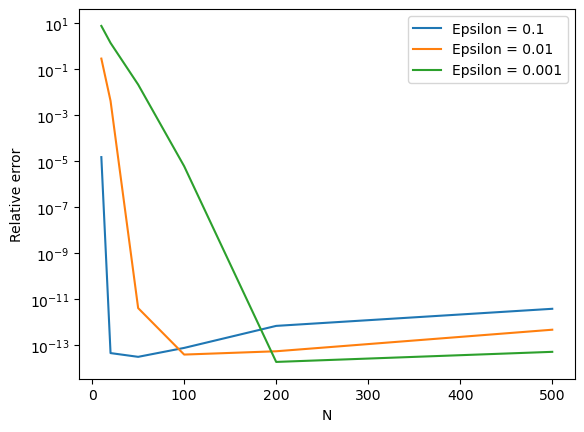

In [60]:
plot_approximations = False
epsilons = [0.1,0.01,0.001]
Ns = [10,20,50,100,200,500]
rel_err = []
for eps in epsilons:
    for N in Ns:
        xGL = JacobiGL(0,0,N)
        ys = (xGL+1)/2
        dV = GradJacobiP(xGL,0,0,N,matrix=True)
        V = JacobiP(xGL,0,0,N,matrix=True).T
        Vi = np.linalg.inv(V)
        D = dV@Vi*2
        LN = -eps*D@D-D
        LN[0,:] = np.concatenate(([1],np.zeros(N)))
        LN[-1,:] = np.concatenate((np.zeros(N),[1]))
        f_tilde = np.concatenate(([0],np.ones(N-1),[0]))
        u_hat = np.linalg.solve(LN,f_tilde)
        rel_err.append(np.linalg.norm(u_hat-true_u(ys,eps))/(np.linalg.norm(true_u(ys,eps))))
        if N == 20 and plot_approximations:
            plt.figure()
            fine_grid = (JacobiGL(0,0,500)+1)/2
            plt.plot(fine_grid,true_u(fine_grid,eps), label="True solution")
            plt.plot(ys,u_hat,'o',label="Approximation")
            plt.xlabel("x")
            plt.title(f"Epsilon = {eps}")
            plt.legend()
plt.figure()
plt.semilogy(Ns,rel_err[0:len(Ns)],label=f"Epsilon = {epsilons[0]}")
plt.semilogy(Ns,rel_err[len(Ns):2*len(Ns)],label=f"Epsilon = {epsilons[1]}")
plt.semilogy(Ns,rel_err[2*len(Ns):(3*len(Ns))],label=f"Epsilon = {epsilons[2]}")
plt.legend()
plt.xlabel("N")
plt.ylabel("Relative error")